# Installation of Tensorflow

In [ ]:
!pip install -q tensorflow

# Dataset Download :

- The dataset used here is the Rice Image Dataset (https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset) . This dataset contains 75K images and has 5 classes which are **Arborio**, **Basmati**, **Ipsala**, **Jasmine** and **Karacadag**, which are the five different varieties of rice.



In [ ]:
import os

if not os.path.exists("/content/rice_dataset/Rice_Image_Dataset"):
    print("Downloading dataset...")
    !wget -q https://www.muratkoklu.com/datasets/Rice_Image_Dataset.zip
    !unzip -q Rice_Image_Dataset.zip -d rice_dataset
    print("Dataset downloaded and extracted.")
else:
    print("Dataset already exists. Skipping download.")


Dataset already exists. Skipping download.


In [ ]:
import os

data_path = "rice_dataset/Rice_Image_Dataset"
os.listdir(data_path)

['Basmati',
 'Karacadag',
 'Ipsala',
 'Arborio',
 'Jasmine',
 'Rice_Citation_Request.txt']

## Load and Preprocessing of Dataset :

We have taken the standard image size as 244 * 244 ( acts as input for VGG16 and RESNET50) and as the dataset contains 75,000 images we chose 2000 images at random to implement this experiment.

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
import os
import random

IMG_SIZE = 224
DATASET_SIZE = 2000
data_path = "/content/rice_dataset/Rice_Image_Dataset"

label_map = {
    name: idx
    for idx, name in enumerate(sorted(os.listdir(data_path)))
    if os.path.isdir(os.path.join(data_path, name))
}

file_paths = []
labels     = []
for label_name, label_idx in label_map.items():
    folder = os.path.join(data_path, label_name)
    for img_file in os.listdir(folder):
        file_paths.append(os.path.join(folder, img_file))
        labels.append(label_idx)

random.seed(42)
sample_indices = random.sample(range(len(file_paths)), DATASET_SIZE)

X_sampled = []
y_sampled = []
for i in tqdm(sample_indices, desc="Loading sampled images"):
    img = cv2.imread(file_paths[i])
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    X_sampled.append(img)
    y_sampled.append(labels[i])

X_sampled = np.array(X_sampled)
y_sampled = np.array(y_sampled)

print(f"Sampled data shape: {X_sampled.shape}, {y_sampled.shape}")
print(f"Label map :",label_map)



Loading sampled images: 100%|██████████| 2000/2000 [00:00<00:00, 2038.05it/s]


Sampled data shape: (2000, 224, 224, 3), (2000,)
Label map : {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


## Data Exploration :

The dataset is visualised on different aspects :

- Displaying the output of how the image is in each class as a reference.
- We can see that the subset of the datset has equal data samples from every class.
- the next shows the mean image per class, which takes the mean of the image
- Next graph displays the pixel intensity graph of the overall sampled dataset

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples(X, y, label_map):
    inv_map = {v: k for k, v in label_map.items()}
    shown = set()

    plt.figure(figsize=(12, 6))
    count = 0

    for class_id in sorted(label_map.values()):
        for idx in range(len(y)):
            if y[idx] == class_id:
                plt.subplot(1, 5, count + 1)
                plt.imshow(X[idx])
                plt.title(inv_map[class_id])
                plt.axis('off')
                count += 1
                break

    plt.tight_layout()
    plt.show()



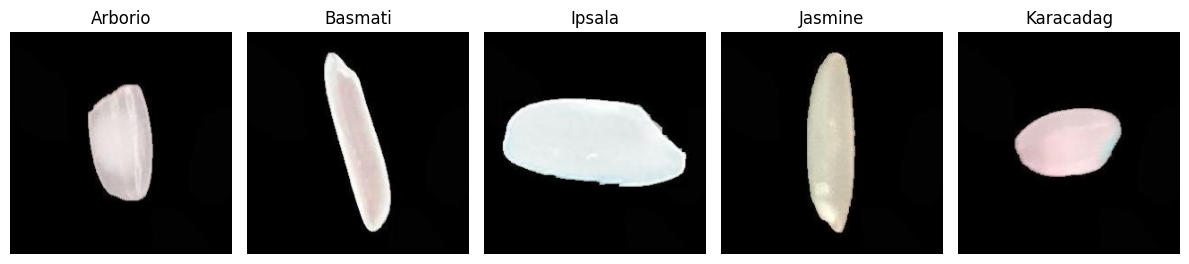

In [ ]:
show_samples(X_sampled, y_sampled, label_map)

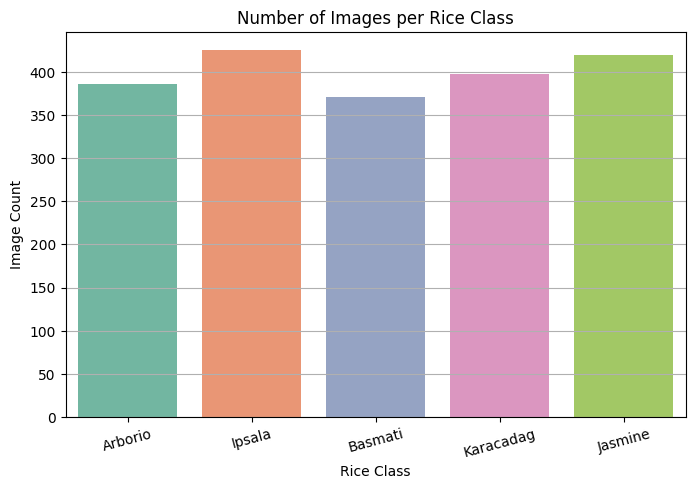

In [ ]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame({'label': y_sampled})
df['label'] = df['label'].map({v: k for k, v in label_map.items()})

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', hue='label', legend=False, palette='Set2')
plt.title("Number of Images per Rice Class")
plt.xlabel("Rice Class")
plt.ylabel("Image Count")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()


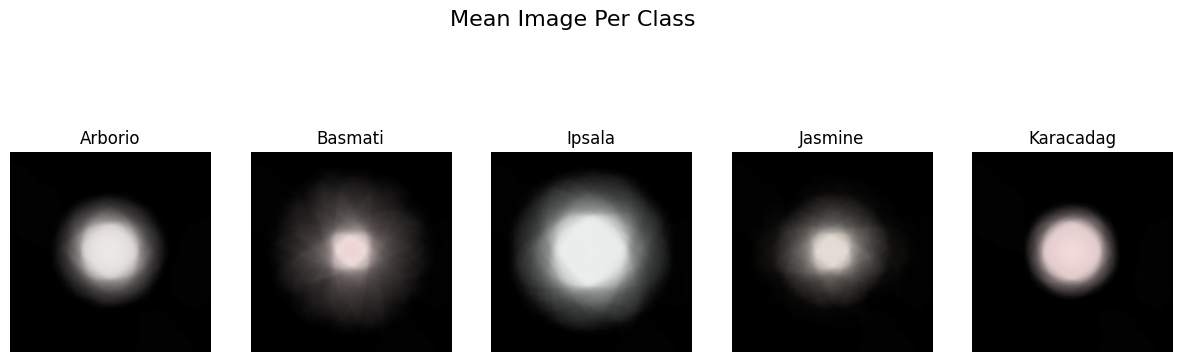

In [ ]:
def mean_image_by_class(X, y, label_map):
    fig, axs = plt.subplots(1, len(label_map), figsize=(15, 5))
    inv_map = {v: k for k, v in label_map.items()}

    for class_id in label_map.values():
        class_imgs = X[y == class_id]
        mean_img = np.mean(class_imgs, axis=0).astype(np.uint8)
        axs[class_id].imshow(mean_img)
        axs[class_id].axis('off')
        axs[class_id].set_title(inv_map[class_id])

    plt.suptitle("Mean Image Per Class", fontsize=16)
    plt.show()

mean_image_by_class(X_sampled, y_sampled, label_map)

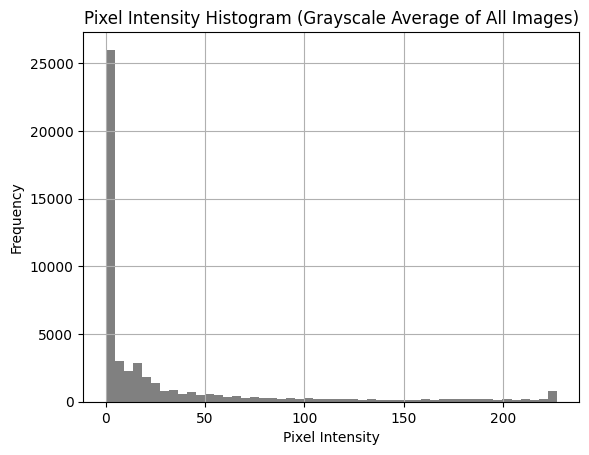

In [ ]:
gray_vals = cv2.cvtColor(np.mean(X_sampled, axis=0).astype(np.uint8), cv2.COLOR_RGB2GRAY)

plt.hist(gray_vals.ravel(), bins=50, color='gray')
plt.title("Pixel Intensity Histogram (Grayscale Average of All Images)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Train-Validation-Test Dataset Split :

The subset of the Rice ataset is divided as follows :

- Training : 70 %
- Validation : 10 %
- Testing : 20 %

This division was applied in the research paper. Before diving the dataset we arw converting the image to **float32** and normalizing the images



In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X = X_sampled.astype('float32') / 255.0

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_sampled, test_size=0.20, stratify=y_sampled, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42
)

print("Training Dataset Size:",X_train.shape[0])
print("Validation Dataset Size:",X_val.shape[0])
print("Testing Dataset Size:",X_test.shape[0])

Training Dataset Size: 1400
Validation Dataset Size: 200
Testing Dataset Size: 400


# Creating Tensorflow pipeline for efficient data loading :

We are divind the training , validation and testing datasets to batches of size 32 and we are assigning tensoflow with autotune that tells Tensorflow to automatically choose the best number of threads for prefetching data. We are also randomizing the order of the samples that provides generalization during training.

In [ ]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def create_dataset(X, y, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = create_dataset(X_train, y_train, batch_size=BATCH_SIZE)
val_ds   = create_dataset(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
test_ds  = create_dataset(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False)

---
# Initalizing the base VGG16 model :

- We are using the pretrained VGG16 Convolusional Base from Keras for image classification or transfer learning.
- We have loaded pre-trained weights from ImageNet and also excluded the final fully connected layers (classifier head)
- We defined the input image size based on our dataset which is (224,224,3)

---

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

num_classes = len(label_map)

vgg_base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

We freeze the convolusional base so its weights are not updated during training. We created a custom classification head on top of the VGG16 base , which is a fully connected layer and to prevent overfitting , we randomly dropped 50 % of the units during training. The final output layer promotes multi-class classification predicting probabilities for each class.

In [ ]:
vgg_base_model.trainable = False

vgg_model = Sequential([
    vgg_base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Training of VGG16 model for Multi Class Classification

We compiled the VGG16 model with Adam Optimizer and as this is a multi-class classification we are using the loss function which is Categorical Crossentropy. The metrics we will be following during training is accuracy and loss.

In [ ]:
vgg_model.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

We are providing the training and validation dataset . The batch size is 32 and we are running this for 10 epochs.

In [ ]:
vgg_history = vgg_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.4298 - loss: 3.2253 - val_accuracy: 0.9350 - val_loss: 0.2749
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8237 - loss: 0.4806 - val_accuracy: 0.9450 - val_loss: 0.2059
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8720 - loss: 0.3813 - val_accuracy: 0.9550 - val_loss: 0.1727
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9099 - loss: 0.2908 - val_accuracy: 0.9550 - val_loss: 0.1240
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9186 - loss: 0.2350 - val_accuracy: 0.9650 - val_loss: 0.1295
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9237 - loss: 0.2209 - val_accuracy: 0.9550 - val_loss: 0.1070
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9359 - loss: 0.2024 - val_accuracy: 0.9600 - val_loss: 0.0912
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9474 - loss: 0.1711 - val_accuracy: 0.9600 -

# Plot of Results for VGG16 Training and Validation Accuracy:

The plots are created using matplotlib. The observation from the below graph is that as the training progresses there is an increase in the accuracy of the training and validation dataset.

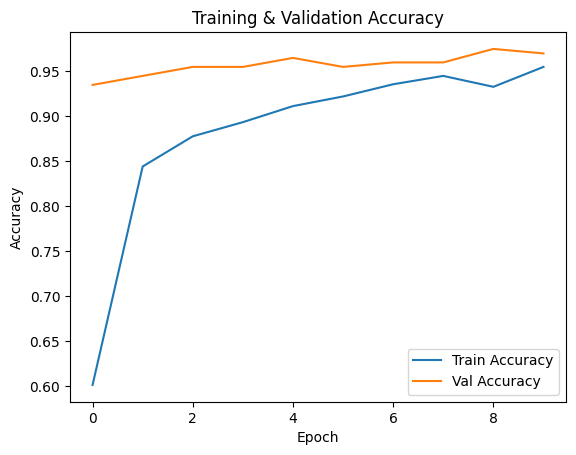

In [ ]:
plt.figure()
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot of Results for VGG16 Training and Validation Loss:

The plots are created using matplotlib. The observation from the below graph is that as the training progresses there is a decrease in the loss of the training and validation dataset.

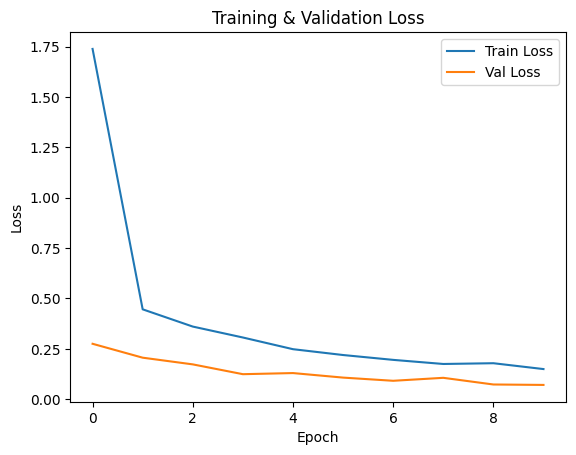

In [ ]:
plt.figure()
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing the VGG16 model on Testing Samples of Subset Dataset:

We have calculatd the test accuracy and test loss on the test dataset created before . As you can see below , we have taken 10 random samples from the testing dataset and we have displayed the true label or ground truth and the prediction from the model.

Test Loss: 0.0557
Test Accuracy: 0.9750
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


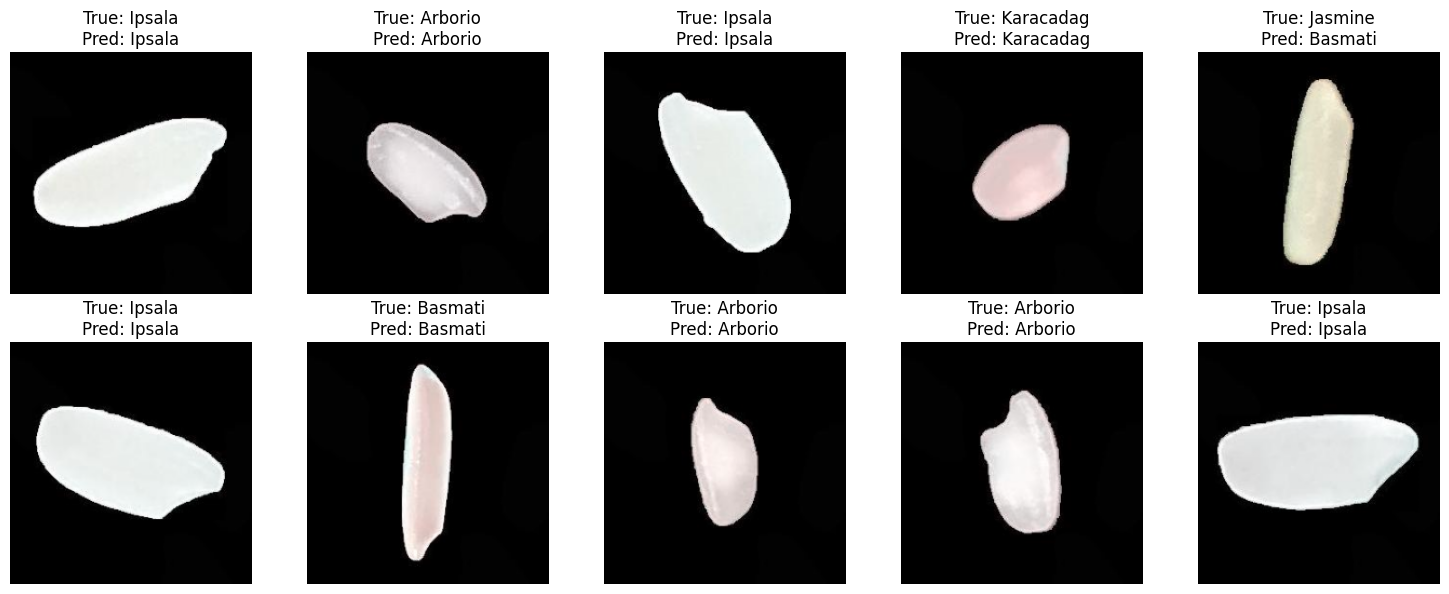

In [ ]:
vgg_test_loss, vgg_test_acc = vgg_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {vgg_test_loss:.4f}")
print(f"Test Accuracy: {vgg_test_acc:.4f}")

y_pred_probs = vgg_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

inv_map = {v: k for k, v in label_map.items()}

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"True: {inv_map[y_test[i]]}\nPred: {inv_map[y_pred[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Analysis on the Test Dataset for VGG16 Model :

We created a confusion matrix on the true labels and the prediction , the model is able to detect most of the images correctly . The numbers in the diagnoals represent the correct classification by the model . The others are wrong classification predicted by the model.

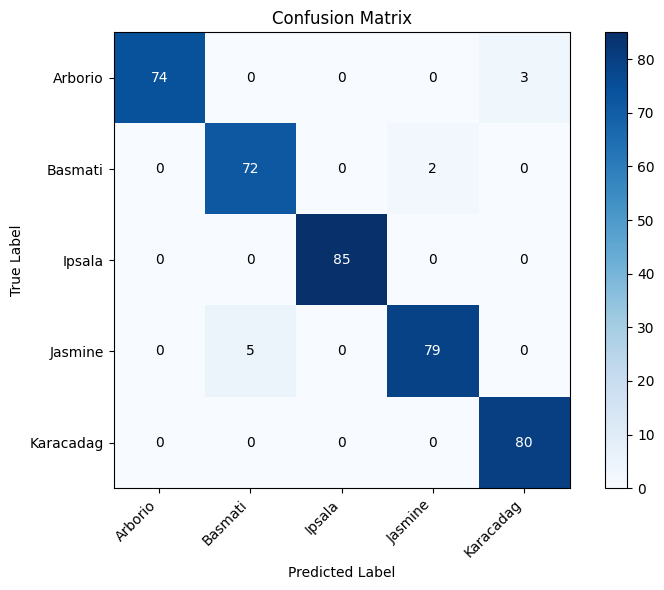

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

vgg_cm = confusion_matrix(y_test, y_pred)
labels = list(inv_map.values())

plt.figure(figsize=(8, 6))
plt.imshow(vgg_cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar()

thresh = vgg_cm.max() / 2
for i in range(vgg_cm.shape[0]):
    for j in range(vgg_cm.shape[1]):
        plt.text(
            j, i,
            format(vgg_cm[i, j], 'd'),
            ha='center',
            va='center',
            color='white' if vgg_cm[i, j] > thresh else 'black'
        )

plt.xticks(np.arange(len(labels)), labels, rotation=45, ha='right')
plt.yticks(np.arange(len(labels)), labels)

plt.tight_layout()
plt.show()

----
# Initalizing the base RESNET50 model :

- We are using the pretrained RESNET50 Convolusional Base from Keras for image classification or transfer learning.
- We have loaded pre-trained weights from ImageNet and also excluded the final fully connected layers (classifier head)
- We defined the input image size based on our dataset which is (224,224,3)
- We have added pooling as None
---

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling=None
)


# Training of VGG16 model for Multi Class Classification

We freeze the convolusional base so its weights are not updated during training. We created a custom classification head on top of the RESNET50 base , which is a fully connected layer . It has a Gloabal Average Polling and a fully connected layer with activation function as RELU , the final layer has the activation layer as softmax.

We compiled the RESNET50 model with Adam Optimizer and as this is a multi-class classification we are using the loss function which is Categorical Crossentropy. The metrics we will be following during training is accuracy and loss.


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model_resnet.trainable = False

resnet_model = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


resnet_model.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

We are providing the training and validation dataset . The batch size is 32 and we are running this for 10 epochs.

In [ ]:
resnet_history = resnet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 339ms/step - accuracy: 0.3471 - loss: 1.6129 - val_accuracy: 0.6550 - val_loss: 1.0435
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5846 - loss: 1.0482 - val_accuracy: 0.7700 - val_loss: 0.8273
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6684 - loss: 0.8370 - val_accuracy: 0.7200 - val_loss: 0.6876
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7276 - loss: 0.7156 - val_accuracy: 0.7500 - val_loss: 0.6248
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7313 - loss: 0.6826 - val_accuracy: 0.8150 - val_loss: 0.5544
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7486 - loss: 0.6087 - val_accuracy: 0.8450 - val_loss: 0.5097
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7714 - loss: 0.5782 - val_accuracy: 0.8950 - val_loss: 0.4919
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7993 - loss: 0.5364 - val_accuracy: 0.8900 -

# Plot of Results for RESNET50 Training and Validation Accuracy:

The plots are created using matplotlib. The observation from the below graph is that as the training progresses there is an increase in the accuracy of the training and validation dataset.

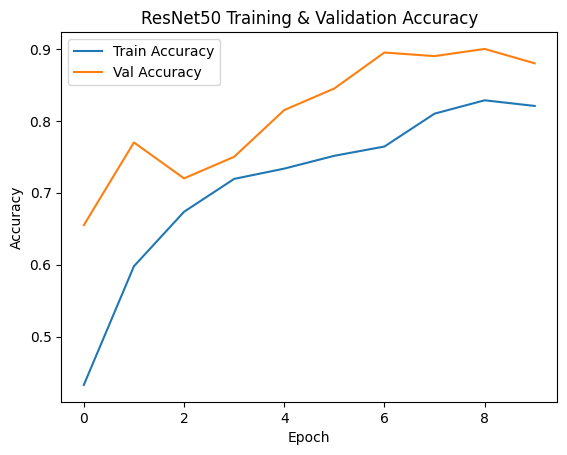

In [ ]:
plt.figure()
plt.plot(resnet_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet50 Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot of Results for RESNET50 Training and Validation Loss:

The plots are created using matplotlib. The observation from the below graph is that as the training progresses there is a decrease in the loss of the training and validation dataset.

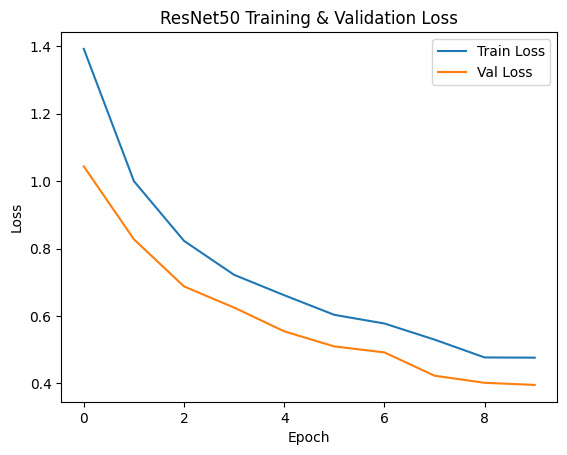

In [ ]:
plt.figure()
plt.plot(resnet_history.history['loss'], label='Train Loss')
plt.plot(resnet_history.history['val_loss'], label='Val Loss')
plt.title('ResNet50 Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing the RESNET50 model on Testing Samples of Subset Dataset:

We have calculatd the test accuracy and test loss on the test dataset created before . As you can see below , we have taken 10 random samples from the testing dataset and we have displayed the true label or ground truth and the prediction from the model.

ResNet50 Test Loss: 0.3898
ResNet50 Test Accuracy: 0.8850
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 352ms/step


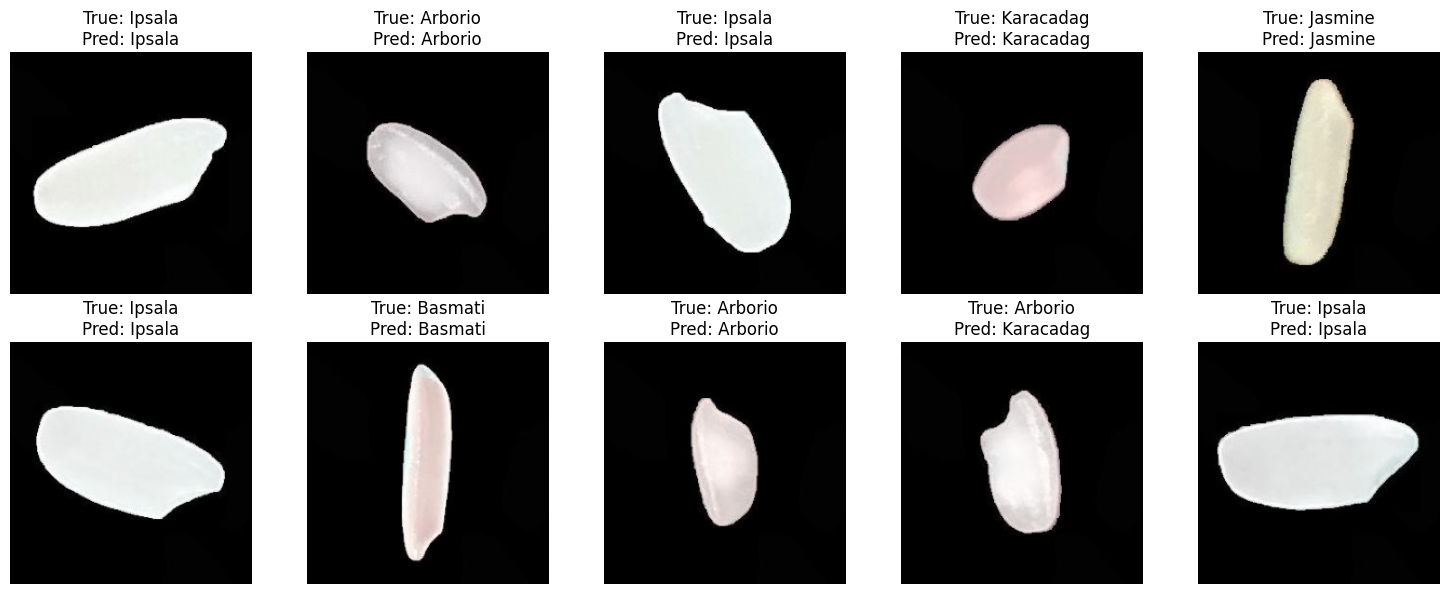

In [ ]:
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(X_test, y_test, verbose=0)
print(f"ResNet50 Test Loss: {resnet_test_loss:.4f}")
print(f"ResNet50 Test Accuracy: {resnet_test_acc:.4f}")

y_pred_probs = resnet_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
inv_map = {v: k for k, v in label_map.items()}

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i])
    plt.title(f"True: {inv_map[y_test[i]]}\nPred: {inv_map[y_pred[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Analysis on the Test Dataset for RESNET50 Model :

We created a confusion matrix on the true labels and the prediction , the model is able to detect most of the images correctly . The numbers in the diagnoals represent the correct classification by the model . The others are wrong classification predicted by the model.

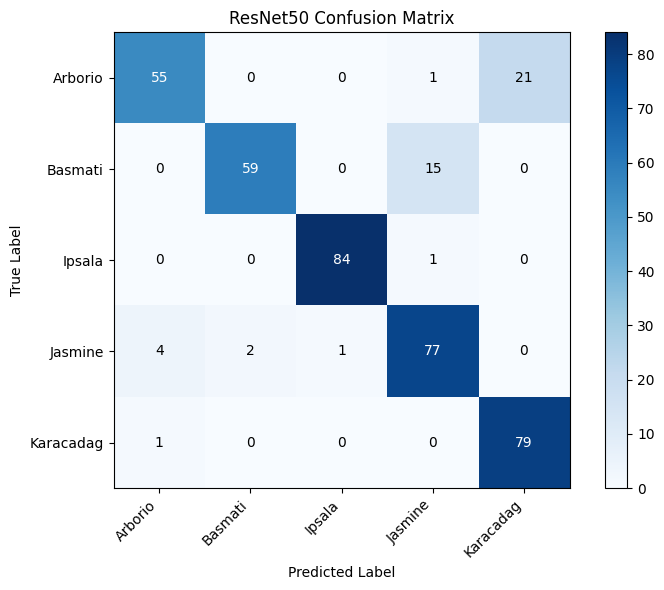

In [ ]:
resnet_cm = confusion_matrix(y_test, y_pred)
labels = [inv_map[i] for i in range(num_classes)]

plt.figure(figsize=(8, 6))
plt.imshow(resnet_cm, interpolation='nearest', cmap='Blues')
plt.title('ResNet50 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar()
thresh = resnet_cm.max() / 2
for i in range(resnet_cm.shape[0]):
    for j in range(resnet_cm.shape[1]):
        plt.text(j, i, f"{resnet_cm[i,j]}",
                 ha="center", va="center",
                 color="white" if resnet_cm[i,j] > thresh else "black")
plt.xticks(np.arange(len(labels)), labels, rotation=45, ha='right')
plt.yticks(np.arange(len(labels)), labels)
plt.tight_layout()
plt.show()

# Overall Comparitative Analysis of Accuracy & Loss of the VGG16 and RESNET50 model

The below shows the overall accuracy and loss for the training and validation datasets given to both the models . The observation is that the accuracy of the VGG16 is comparitively higher and its accuracy is consistantly increasing with every epoch. The same holds for the validation dataset.

The VGG16 starts with a high loss compared to the other model , and overall the loss for every epoch is less compared to the RESNET50 model.

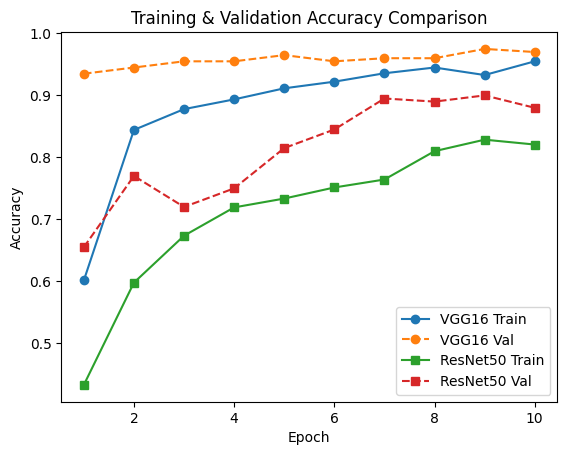

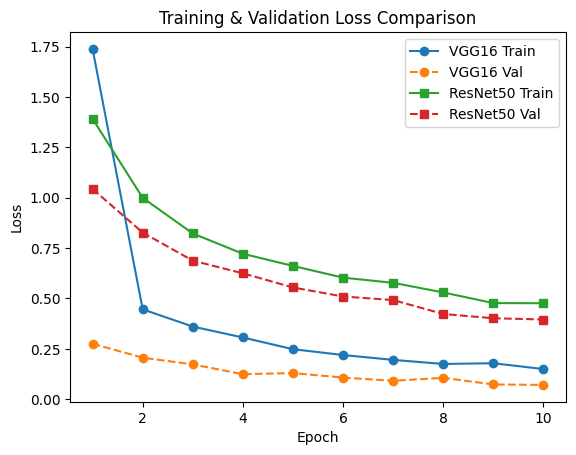

In [ ]:
epochs = range(1, len(vgg_history.history['accuracy']) + 1)

plt.figure()
plt.plot(epochs, vgg_history.history['accuracy'], marker='o', label='VGG16 Train')
plt.plot(epochs, vgg_history.history['val_accuracy'], marker='o', linestyle='--', label='VGG16 Val')
plt.plot(epochs, resnet_history.history['accuracy'], marker='s', label='ResNet50 Train')
plt.plot(epochs, resnet_history.history['val_accuracy'], marker='s', linestyle='--', label='ResNet50 Val')
plt.title('Training & Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, vgg_history.history['loss'], marker='o', label='VGG16 Train')
plt.plot(epochs, vgg_history.history['val_loss'], marker='o', linestyle='--', label='VGG16 Val')
plt.plot(epochs, resnet_history.history['loss'], marker='s', label='ResNet50 Train')
plt.plot(epochs, resnet_history.history['val_loss'], marker='s', linestyle='--', label='ResNet50 Val')
plt.title('Training & Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

This is the table which displays all the metrics on the training , validation and testing datasets which was used by both the models.

In [ ]:
metrics = {
    'Model': ['VGG16', 'ResNet50'],
    'Train Accuracy': [
        vgg_history.history['accuracy'][-1],
        resnet_history.history['accuracy'][-1]
    ],
    'Val Accuracy': [
        vgg_history.history['val_accuracy'][-1],
        resnet_history.history['val_accuracy'][-1]
    ],
    'Train Loss': [
        vgg_history.history['loss'][-1],
        resnet_history.history['loss'][-1]
    ],
    'Val Loss': [
        vgg_history.history['val_loss'][-1],
        resnet_history.history['val_loss'][-1]
    ],
    'Test Accuracy': [vgg_test_acc, resnet_test_acc],
    'Test Loss':     [vgg_test_loss, resnet_test_loss]
}

df_summary = pd.DataFrame(metrics)
df_summary

,Model,Train Accuracy,Val Accuracy,Train Loss,Val Loss,Test Accuracy,Test Loss
0,VGG16,0.955000,0.97,0.149368,0.070655,0.975,0.055712
1,ResNet50,0.820714,0.88,0.476331,0.395459,0.885,0.389779


# Gaussian Noise:

This is the function that takes the image , mean and standard deviation as an input. It is a typ of random noise where the values are drawn from a normal distribution (bell-shaped curve) .

The Gaussian Noise is defined as :

$$
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{ -\frac{(x - \mu)^2}{2\sigma^2} }
$$

For each pixel 𝒳 in an image :

$$
x_{\text{noisy}} = x + \epsilon \quad \text{where} \quad \epsilon \sim \mathcal{N}(\mu, \sigma^2)
$$




In [ ]:
import numpy as np

def add_gaussian_noise(images, mean=0.0, std=0.1):
    """
    Add Gaussian noise to images.

    Parameters:
    -----------
    images : np.ndarray
        Array of images, shape (N, H, W, C), dtype float32, values in [0,1].
    mean : float
        Mean of the Gaussian noise.
    std : float
        Standard deviation of the Gaussian noise.

    Returns:
    --------
    noisy_images : np.ndarray
        Images with added Gaussian noise, clipped back to [0,1].
    """
    noise = np.random.normal(loc=mean, scale=std, size=images.shape).astype(np.float32)
    noisy_images = images + noise

    return np.clip(noisy_images, 0.0, 1.0)


# Evaluation of Addition of Gaussian Noise on the Test Dataset of different Standard Deviations

The below code evaluates the robustness of two deep learning models : VGG16 and ResNet50—against varying levels of Gaussian noise added to the test dataset.A list of standard deviation values defines the intenstiy of noise applied to teh test dataset. For each noise level the gaussian noise is added to the test image and evaluated .The evaluation returns the loss and accuracy, which are recorded for both VGG16 and ResNet50. These results are compiled into a pandas DataFrame.

In [ ]:
import numpy as np
import pandas as pd

BATCH_SIZE = 32
variants = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 3, 5, 7, 9]

results = []
for var in variants:
    X_noisy = add_gaussian_noise(X_test, mean=0.0, std=var)

    loss_vgg, acc_vgg = vgg_model.evaluate(
        X_noisy, y_test, batch_size=BATCH_SIZE, verbose=0
    )

    loss_res, acc_res = resnet_model.evaluate(
        X_noisy, y_test, batch_size=BATCH_SIZE, verbose=0
    )

    results.append({
        'variant': var,
        'VGG16 Test Loss': loss_vgg,
        'ResNet50 Test Loss': loss_res,
        'VGG16 Test Accuracy': acc_vgg,
        'ResNet50 Test Accuracy': acc_res
    })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


 variant  VGG16 Test Loss  ResNet50 Test Loss  VGG16 Test Accuracy  ResNet50 Test Accuracy
     0.1         0.091384            0.526133               0.9650                  0.7625
     0.2         0.362854            0.955461               0.8375                  0.5525
     0.3         1.086346            1.636482               0.5375                  0.3750
     0.4         1.913560            2.127842               0.4225                  0.3000
     0.6         2.810026            2.728065               0.3925                  0.2850
     0.8         3.175332            3.100902               0.3975                  0.2150
     1.0         3.518163            3.352969               0.3475                  0.2100
     3.0         4.620660            4.020796               0.1850                  0.2100
     5.0         4.677307            4.146552               0.1850                  0.2100
     7.0         4.679777            4.164486               0.1850                  0.2100

# Analyis of the Accuracy on VGG16 and ResNet50 on Test Dataset:

The below graph shows a notable observation for both the models . It shows that as there is an increase in the standard deviation, more noise is added and it is difficult for the models to interpret their class . The accuracy for both the models decrease consistently . The major hit of accuracy is seen in the RESNET50 model.

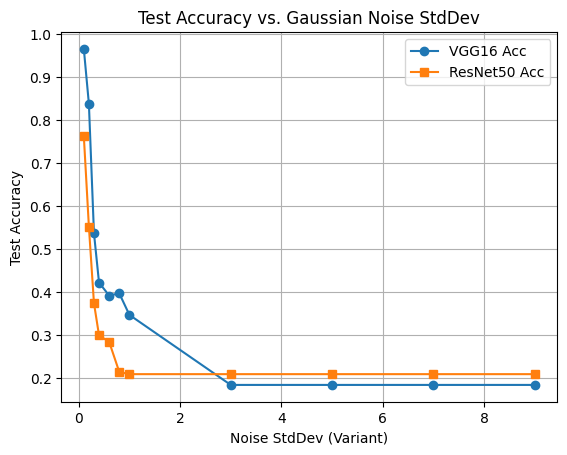

In [ ]:
variants = df_results['variant']

plt.figure()
plt.plot(variants, df_results['VGG16 Test Accuracy'], marker='o', label='VGG16 Acc')
plt.plot(variants, df_results['ResNet50 Test Accuracy'], marker='s', label='ResNet50 Acc')
plt.title('Test Accuracy vs. Gaussian Noise StdDev')
plt.xlabel('Noise StdDev (Variant)')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Analyis of the Loss on VGG16 and ResNet50 on Test Dataset:

The below graph shows a notable observation for both the models . It shows that as there is an increase in the standard deviation, more noise is added and it is difficult for the models to interpret their class . The loss extensively increases for both the models . The major hit of loss is seen in the the VGG16
model.

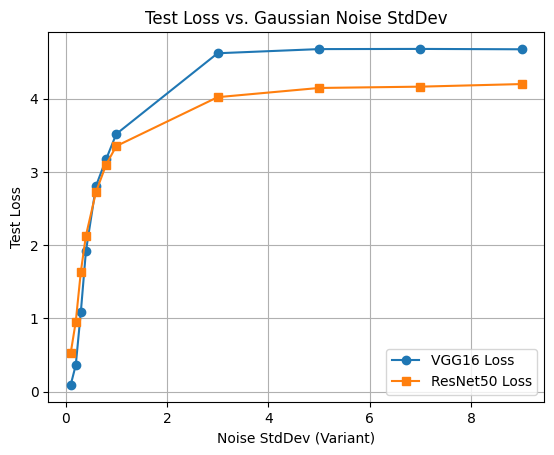

In [ ]:
plt.figure()
plt.plot(variants, df_results['VGG16 Test Loss'], marker='o', label='VGG16 Loss')
plt.plot(variants, df_results['ResNet50 Test Loss'], marker='s', label='ResNet50 Loss')
plt.title('Test Loss vs. Gaussian Noise StdDev')
plt.xlabel('Noise StdDev (Variant)')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)
plt.show()